In [1]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
import csv
# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
y = []
x_names = []

with open('training_norm.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
#     print(reader)
    with open('training_norm_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
#         c = 0
        for rows in reader:
#             if c > 100:
#                 break
            f = rows[0]
            a = float(rows[1])
            s = float(rows[2])
            y.append([a,s])
            filename = str(f) + '.png'
            x_names.append(filename)
  

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split( x_names, y, test_size=0.15)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 11724
Validation data: 2069


In [103]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training, shuffle=True):
    num_batches = int(np.floor(len(image_paths) / batch_size))
    bc = 0
    print('bc ', bc)
    indexes = np.arange(len(image_paths))
    if shuffle == True:
            np.random.shuffle(indexes)
    while True:
        batch_images = []
        batch_steering_angles = []
        path = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/training_data/'
       
        for i in range(batch_size):
            index = bc * batch_size + i   
            print('bc, i, index, indexes, is_training = ', bc, i, index, indexes[index], is_training)
            image_path = path + image_paths[indexes[index]]
            image = cv2.imread(image_path)
            steering_angle = steering_angles[indexes[index]]
#             if is_training:
#                 # training: augment image
#                 image, steering_angle = random_augment(image, steering_angle)
             
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
        
        bc += 1 
        if bc > num_batches:
            bc = 0
            if shuffle == True:
                np.random.shuffle(indexes)   
                
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
        
        
            

In [42]:
def img_preprocess(image):
    height, _, _ = image.shape
#     image = image[int(height/2):,:,:]
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Nvidia model said it is best to use YUV color space
#     image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (160,120)) # input image size (200,66) Nvidia model
#     image[85:,:] = 255 - image[85:,:]
    image = image / 255 # normalizing
    return image

In [99]:
ncol = 2
nrow = 2
train_gen = image_data_generator(X_train, y_train, nrow, True)
valid_gen = image_data_generator(X_valid, y_valid, nrow, False)

bc, i, index, indexes, is_training =  8 0 16 9026 True
bc, i, index, indexes, is_training =  8 1 17 1556 True
bc, i, index, indexes, is_training =  8 0 16 1121 False
bc, i, index, indexes, is_training =  8 1 17 1041 False


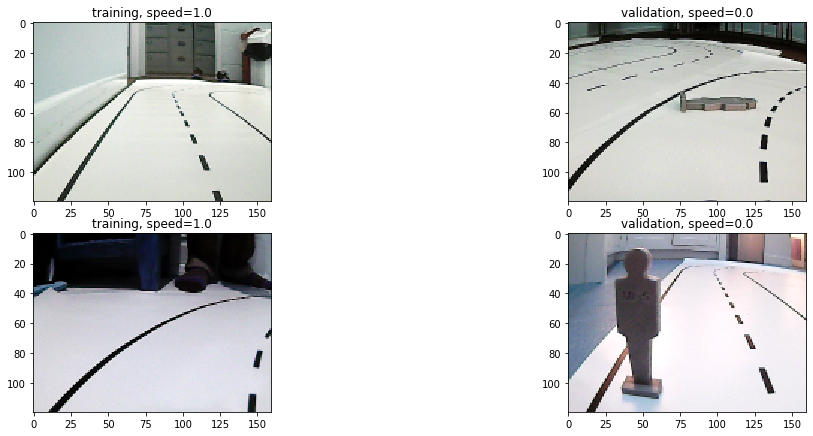

In [109]:

X_train_batch, y_train_batch = next(train_gen)
X_valid_batch, y_valid_batch = next(valid_gen)

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, speed=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, speed=%s" % y_valid_batch[i])

In [91]:
np.shape(d)

(5862,)

In [35]:

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels, image_path,
                 batch_size, is_training, shuffle=True):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
#         self.mask_path = mask_path
#         self.to_fit = to_fit
        self.batch_size = batch_size
#         self.dim = dim
#         self.n_channels = n_channels
#         self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         print('indexes ',indexes)
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        list_IDs_temp = indexes

        # Generate data
        X = self._generate_X(list_IDs_temp)

#         if self.to_fit:
        y = self._generate_y(list_IDs_temp)
        yield (np.asarray(X), np.asarray(y))
#         else:
#             return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
        X = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            print(ID)
            image_path = self.image_path + self.list_IDs[ID]
            image = cv2.imread(image_path)
            X.append(image)
#             X[i,] = self._load_grayscale_image(self.image_path + self.labels[ID])

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
#         y = np.empty((self.batch_size, *self.dim), dtype=int)
        y = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
#             y[i,] = self._load_grayscale_image(self.mask_path + self.labels[ID])
            y.append(self.labels[ID])
        return y

#     def _load_grayscale_image(self, image_path):
#         """Load grayscale image
#         :param image_path: path to image to load
#         :return: loaded image
#         """
#         img = cv2.imread(image_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img = img / 255
#         return img

In [76]:
g = 9.8

def down_data(h):
    t = 0
    print(t)
    while h > 0:
        t += .0001
        h = -4.9*t**2 + 1
        v = g*t
        yield h, v

# for h, v in down_data(1):
# print(h,v)
print(next(down_data(1)))


0
(0.999999951, 0.0009800000000000002)


In [6]:
path_file = '/Users/kamyab/Documents/UoN/MLiS_2/Project/new_objects/object.v2-12.voc/Augmented/'
path_flip = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Flipped Augmented/'
# test_names = np.arange(1020) + 1

for file in os.listdir(path_file):
    if file == '.DS_Store' or file == '.DS_S.xml':
        continue
    
    if '_' in file:
        f=(file.split('_'))
    else:
        f=(file.split('.'))
    
    img = cv2.imread(path_file + file)
    img = cv2.flip(img, 1)
    fname = f[0] + '-f_' + f[1] + '.png'
#     plt.imshow(img)
    cv2.imwrite(path_flip+fname, img)
    print(file, fname)

# with open(path_flip + 'train_flip.csv', mode='w', newline='') as submission:
#     writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     writer.writerow(['image_id', 'angle', 'speed'])
 
# #     fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
#     for i, name in enumerate(x_names):     
# #         img = cv2.imread(path_file + name)
# #         img = cv2.flip(img, 1)
#         f = name.split('.')[0] 
#         row = y[i]        
# #         writer.writerow([f, row[0], row[1]])
# #         filename = path_flip + f + '.png'
# #         cv2.imwrite(filename, img)
        
#         print(f, row[0], row[1])
#         f = f + '-f'
#         row[0] = 1 - row[0]
# #         writer.writerow([f, row[0], row[1]])
#         print(f, row[0], row[1])



2977_png.rf.e5a68c04019875564d4bd0ce78ed1653.jpg 2977-f_png.rf.e5a68c04019875564d4bd0ce78ed1653.jpg.png
1137_png.rf.7d88fdb4eda5e8e4a962556b6e0ab7ac.jpg 1137-f_png.rf.7d88fdb4eda5e8e4a962556b6e0ab7ac.jpg.png
3904_png.rf.6fac54d8b50b69b3d4330eb28e85a38e.jpg 3904-f_png.rf.6fac54d8b50b69b3d4330eb28e85a38e.jpg.png
3474_png.rf.0334fc582f078557a73838eb7abb8ca8.jpg 3474-f_png.rf.0334fc582f078557a73838eb7abb8ca8.jpg.png
4949_png.rf.8dab101ef580fa186119d02cea8d3f2f.jpg 4949-f_png.rf.8dab101ef580fa186119d02cea8d3f2f.jpg.png
2636_png.rf.6681967d122253a776c8e6a98ee6c32e.jpg 2636-f_png.rf.6681967d122253a776c8e6a98ee6c32e.jpg.png
10548_png.rf.000e08c95b4a2d1b293fdac4895edeb9.jpg 10548-f_png.rf.000e08c95b4a2d1b293fdac4895edeb9.jpg.png
5753_png.rf.88f949ed4e1b916372789b59b882a2bf.jpg 5753-f_png.rf.88f949ed4e1b916372789b59b882a2bf.jpg.png
7591_png.rf.63f11b7b7729628ab727a64bc821c7a0.jpg 7591-f_png.rf.63f11b7b7729628ab727a64bc821c7a0.jpg.png
10640_png.rf.f94d304e5c4baf93393884c8e3e97d4e.jpg 10640-f_png.

In [136]:
'56757.png'.split('.')[0]  + '-f'

'56757-f'

In [5]:
path_file = '/Users/kamyab/Documents/UoN/MLiS_2/Project/new_objects/object.v2-12.voc/Augmented/'
path_flip = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Flipped Augmented/'

# test_names = np.arange(1020) + 1
with open(path_flip + 'train_flip_correct.csv', mode='w', newline='') as submission:
    writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['image_id', 'angle', 'speed'])
 
#     fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
    for i, name in enumerate(x_names):     
        img = cv2.imread(path_file + name)
        img = cv2.flip(img, 1)
        f = name.split('.')[0] 
        row = y[i]  
        print(f, row[0], row[1])
        writer.writerow([f, row[0], row[1]])
        filename = path_flip + f + '-f' + '.png'
        cv2.imwrite(filename, img)
        
        
        f = f + '-f'
        row[0] = 1 - row[0]
        print(f, row[0], row[1])
        writer.writerow([f, row[0], row[1]])
        


1 0.4375 0.0


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'
